# Apartment Price Prediction
## 1. Đặt vấn đề
Bài toán của nhóm đặt ra là Dự đoán giá chung cư dựa vào dữ liệu từ trang https://batdongsan.vn/ban-can-ho-chung-cu.

Mục tiêu của nhóm sẽ là tìm ra mô hình Machine Learning tốt nhất để dự đoán giá chung cư bằng cách sử dụng các kiến thức được dạy trong nội dung môn học một cách chính xác, đúng kỹ thuật và có sự cân nhắc. Các kiến thức bao gồm: data scraping, data cleaning, EDA, feature selection, các mô hình Machine Learning cơ bản, hypertuning, evaluation...

## 2. Thu thập dữ liệu
Nhóm đã cào dữ liệu (scraping) từ website ở trên và đã sử dụng LLM để tách trích các feature và thu được bộ dữ liệu gồm các biến sau:
* Giá cả: Giá của phòng chung cư (Biến mục tiêu, đơn vị tỷ đồng)
* Diện tích: Diện tích của phòng chung cư (Đơn vị mét vuông)
* Hướng nhà: Hướng nhà của phòng chung cư
* Hướng ban công: Hướng ban công của phòng chung cư
* Số phòng ngủ: Số phòng ngủ trong phòng chung cư
* Số nhà vệ sinh: Số phòng vệ sinh trong phòng chung cư
* Latitude: Vĩ độ của chung cư
* Longitude: Kinh độ của chung cư
* Vị trí: Địa chỉ của chung cư (Quận/Huyện và Tỉnh/Thành phố)
* Số tầng: Số tầng của phòng đó ở chung cư
* Giấy tờ rõ ràng: Có sổ hồng, sổ đỏ, chứng từ rõ ràng, chính chủ
* Hỗ trợ vay vốn ngân hàng: Có hỗ trợ vay vốn để trả góp khi mua phòng chung cư
* Bàn giao nội thất: Phòng chung cư có sẵn nội thất hay không

P/S: Chi tiết source code nhóm đã để ở file .py

## 3. Phương pháp

Thiết lập môi trường phù hợp để thực hiện các phương pháp.

In [140]:
!pip install lmdiag
!pip install pyyaml==5.4.1
!pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

  Using cached PyYAML-5.4.1.tar.gz (175 kB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
  Using cached https://github.com/ydataai/pandas-profiling/archive/master.zip
  Preparing metadata (setup.py) ... done


In [141]:
#!pip install lmdiag
#!pip install pyyaml==5.4.1
#import sys
#!{sys.executable} -m pip install pandas-profiling
#!pip install -U matplotlib==3.9.0

In [142]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import lmdiag
import itertools
from scipy import stats
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from collections import OrderedDict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

### a. Đọc dữ liệu


In [143]:
# Mount data từ Google Drive sang Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [144]:
# Load Dataset
path = '/content/drive/MyDrive/NhapMonKHDL/data_geocode.xlsx' # Đường dẫn tới file cần đọc
df = pd.read_excel(path)  # read_excel từ đường dẫn và trả về dưới dạng một DataFrame
df.head()

Giá cả  Diện tích Hướng nhà Hướng ban công  Số phòng ngủ  Số nhà vệ sinh  \
0    3.30       88.0       NaN            NaN           3.0             2.0   
1    2.60       80.0   Tây-Nam       Đông-Bắc           3.0             2.0   
2    2.05      100.0       NaN            NaN           NaN             NaN   
3    1.40       45.0       NaN            NaN           1.0             1.0   
4    3.45       83.9   Tây-Bắc       Đông-Bắc           3.0             2.0   

      Latitude     Longitude  Vị trí Số tầng  Giấy tờ rõ ràng  \
0  209589392.0  1.058429e+09  Hà Nội     NaN                1   
1  209997545.0  1.059421e+09  Hà Nội     NaN                1   
2  108432686.0  1.068667e+09   other     NaN                1   
3  109570181.0  1.067202e+09   other     NaN                1   
4  209997545.0  1.059421e+09  Hà Nội     NaN                1   

   Hỗ trợ vay vốn ngân hàng  Bàn giao nội thất  
0                         0                  0  
1                         0                  0  
2                         0                  0  
3                         1                  1  
4                         0                  1

In [145]:
# Load Dataset
#path = 'C:\\Users\\admin\\OneDrive - VNU-HCMUS\\Desktop\\data_geocode.xlsx' # Đường dẫn tới file cần đọc
#df = pd.read_excel(path)  # read_excel từ đường dẫn và trả về dưới dạng một DataFrame
#df.head()

### b. Mô tả và làm sạch dữ liệu
### Đổi tên biến
Vì tên các biến hiện tại có dấu và có khoảng cách, gây khó khăn cho các bước xử lý sau nên ta sẽ đổi lại tên cho các biến.

In [146]:
df = df.rename(columns={'Giá cả': 'gia_ca',
                        'Diện tích': 'dien_tich',
                        'Hướng nhà': 'huong_nha',
                        'Hướng ban công': 'huong_ban_cong',
                        'Số phòng ngủ': 'phong_ngu',
                        'Số nhà vệ sinh': 'phong_ve_sinh',
                        "Latitude": 'vi_do',
                        "Longitude": 'kinh_do',
                        'Vị trí': 'vi_tri',
                        'Số tầng': 'so_tang',
                        'Giấy tờ rõ ràng': 'giay_to',
                        'Hỗ trợ vay vốn ngân hàng': 'ho_tro_vay',
                        'Bàn giao nội thất': 'noi_that'
                        })

### Mô tả dữ liệu

In [147]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'-'))
    print(dataframe.head(head))
    print(' TAIL '.center(70,'-'))
    print(dataframe.tail(head))
    print(' MISSING VALUES '.center(70,'-'))
    print(dataframe.isnull().sum())
    print(' DUPLICATED VALUES '.center(70,'-'))
    print(dataframe.duplicated().sum())

check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 4181
Columns: 13
------------------------------- TYPES --------------------------------
gia_ca            float64
dien_tich         float64
huong_nha          object
huong_ban_cong     object
phong_ngu         float64
phong_ve_sinh     float64
vi_do             float64
kinh_do           float64
vi_tri             object
so_tang            object
giay_to             int64
ho_tro_vay          int64
noi_that            int64
dtype: object
-------------------------------- HEAD --------------------------------
   gia_ca  dien_tich huong_nha huong_ban_cong  phong_ngu  phong_ve_sinh  \
0    3.30       88.0       NaN            NaN        3.0            2.0   
1    2.60       80.0   Tây-Nam       Đông-Bắc        3.0            2.0   
2    2.05      100.0       NaN            NaN        NaN            NaN   
3    1.40       45.0       NaN            NaN        1.0            1.0   
4    3.45       83.9   Tây-Bắc       

In [148]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # Giới hạn (Threshold) cho số giá trị duy nhất (unique value) để được coi là 1 biến categorical (cat) hoặc high-carndinality categorical (car)
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'Categorical Columns: {len(cat_cols)}')
    print(f'Numerical Columns: {len(num_cols)}')
    print(f'Categorical but cardinal: {len(cat_but_car)}')
    print(f'Numerical but categorical: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=10)
print(cat_cols, num_cols, cat_but_car, sep='\n')

Observations: 4181
Variables: 13
Categorical Columns: 4
Numerical Columns: 6
Categorical but cardinal: 3
Numerical but categorical: 3
['vi_tri', 'giay_to', 'ho_tro_vay', 'noi_that']
['gia_ca', 'dien_tich', 'phong_ngu', 'phong_ve_sinh', 'vi_do', 'kinh_do']
['huong_nha', 'huong_ban_cong', 'so_tang']


**Nhận xét nhanh:**
*   Có 9 biến bị khuyết dữ liệu là: 'gia_ca', 'dien_tich', 'huong_nha', 'huong_ban_cong', 'phong_ngu', 'phong_ve_sinh', 'kinh_do', 'vi_do' và 'so_tang'.
*   Biến 'huong_nha', 'huong_ban_cong' và 'so_tang' lần lượt bị khuyết khoảng 43.8%, 40.2% và 74.6%. Các biến này không nên điền khuyết (Fill) vì khuyết quá nhiều.
*   Biến 'gia_ca', 'dien_tich', 'phong_ngu', 'phong_ve_sinh', 'kinh_do' và 'vi_do' lần lượt bị khuyết khoảng 10.9%, 3.4%, 7.3%, 13.2%, 5.2% và 5.2%. Ta có thể điền khuyết để xử lý biến này vì phần khuyết nhỏ.
*   Có 735 giá trị trùng nhau, cần phải loại bỏ để tránh việc model bị học quá nhiều 1 quan trắc nào đó.

### Loại bỏ các biến không sử dụng và các giá trị trùng nhau

Loại bỏ 3 biến 'so_tang', 'huong_nha' và 'huong_ban_cong' vì bị khuyết quá nhiều.

In [149]:
df.drop(['so_tang', 'huong_nha', 'huong_ban_cong'], axis = 1, inplace = True)

Loại bỏ các giá trị trùng nhau.

In [150]:
df = df.drop_duplicates()

Loại bỏ các giá trị khuyết của biến 'gia_ca' vì đây là biến phụ thuộc, nếu không xử lý tốt rất có thể sẽ ảnh hưởng tới sự chính xác của mô hình.

In [151]:
df.dropna(axis=0, subset=['gia_ca'], inplace=True)

<ipython-input-151-e6775e422a42>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=0, subset=['gia_ca'], inplace=True)


In [152]:
check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 2783
Columns: 10
------------------------------- TYPES --------------------------------
gia_ca           float64
dien_tich        float64
phong_ngu        float64
phong_ve_sinh    float64
vi_do            float64
kinh_do          float64
vi_tri            object
giay_to            int64
ho_tro_vay         int64
noi_that           int64
dtype: object
-------------------------------- HEAD --------------------------------
   gia_ca  dien_tich  phong_ngu  phong_ve_sinh        vi_do       kinh_do  \
0    3.30       88.0        3.0            2.0  209589392.0  1.058429e+09   
1    2.60       80.0        3.0            2.0  209997545.0  1.059421e+09   
2    2.05      100.0        NaN            NaN  108432686.0  1.068667e+09   
3    1.40       45.0        1.0            1.0  109570181.0  1.067202e+09   
4    3.45       83.9        3.0            2.0  209997545.0  1.059421e+09   

   vi_tri  giay_to  ho_tro_vay  noi_t

### Xử lý các biến giả (dummy)

In [153]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe,
                               columns = categorical_cols,
                               drop_first = drop_first)
    return dataframe

In [154]:
df = one_hot_encoder(df, ['vi_tri'])
df.head()

gia_ca  dien_tich  phong_ngu  phong_ve_sinh        vi_do       kinh_do  \
0    3.30       88.0        3.0            2.0  209589392.0  1.058429e+09   
1    2.60       80.0        3.0            2.0  209997545.0  1.059421e+09   
2    2.05      100.0        NaN            NaN  108432686.0  1.068667e+09   
3    1.40       45.0        1.0            1.0  109570181.0  1.067202e+09   
4    3.45       83.9        3.0            2.0  209997545.0  1.059421e+09   

   giay_to  ho_tro_vay  noi_that  vi_tri_Hà Nội  vi_tri_Hồ Chí Minh  \
0        1           0         0           True               False   
1        1           0         0           True               False   
2        1           0         0          False               False   
3        1           1         1          False               False   
4        1           0         1           True               False   

   vi_tri_other  
0         False  
1         False  
2          True  
3          True  
4         False

Đổi tên biến dummy để dễ sử dụng hơn.

In [155]:
df = df.rename(columns={'vi_tri_Hà Nội': 'vi_tri_hn',
                        'vi_tri_Hồ Chí Minh': 'vi_tri_hcm'
                        })

In [156]:
df['vi_tri_hn'] = df['vi_tri_hn'].apply(lambda x: 1 if x == True else 0)
df['vi_tri_hcm'] = df['vi_tri_hcm'].apply(lambda x: 1 if x == True else 0)
df['vi_tri_other'] = df['vi_tri_other'].apply(lambda x: 1 if x == True else 0)

### Thống kê mô tả

In [157]:
df.describe()

gia_ca    dien_tich     phong_ngu  phong_ve_sinh         vi_do  \
count  2783.000000  2758.000000   2585.000000    2460.000000  2.677000e+03   
mean      2.867750    75.076385      7.047969       1.798780  1.554479e+08   
std       1.744076    58.105857    221.020154       1.159749  7.352459e+07   
min       0.125300     5.000000      1.000000       1.000000  1.077490e+05   
25%       1.600000    54.000000      2.000000       1.000000  1.080364e+08   
50%       2.400000    69.000000      2.000000       2.000000  1.646371e+08   
75%       3.700000    82.500000      2.000000       2.000000  2.099975e+08   
max       9.920000  2111.000000  11231.000000      30.000000  1.375367e+09   

            kinh_do      giay_to   ho_tro_vay     noi_that    vi_tri_hn  \
count  2.677000e+03  2783.000000  2783.000000  2783.000000  2783.000000   
mean   9.675310e+08     0.899389     0.358246     0.600791     0.470356   
std    2.955219e+08     0.300867     0.479571     0.489824     0.499210   
min   -1.173755e+09     0.000000     0.000000     0.000000     0.000000   
25%    1.057867e+09     1.000000     0.000000     0.000000     0.000000   
50%    1.059428e+09     1.000000     0.000000     1.000000     0.000000   
75%    1.067845e+09     1.000000     1.000000     1.000000     1.000000   
max    1.092787e+09     1.000000     1.000000     1.000000     1.000000   

        vi_tri_hcm  vi_tri_other  
count  2783.000000   2783.000000  
mean      0.216313      0.313331  
std       0.411804      0.463931  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       0.000000      1.000000  
max       1.000000      1.000000

Dùng pandas profilling để thực hiện EDA nhanh.

In [158]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

In [159]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Kiểm tra mối tương quan theo cặp (Pairwise Correlation).

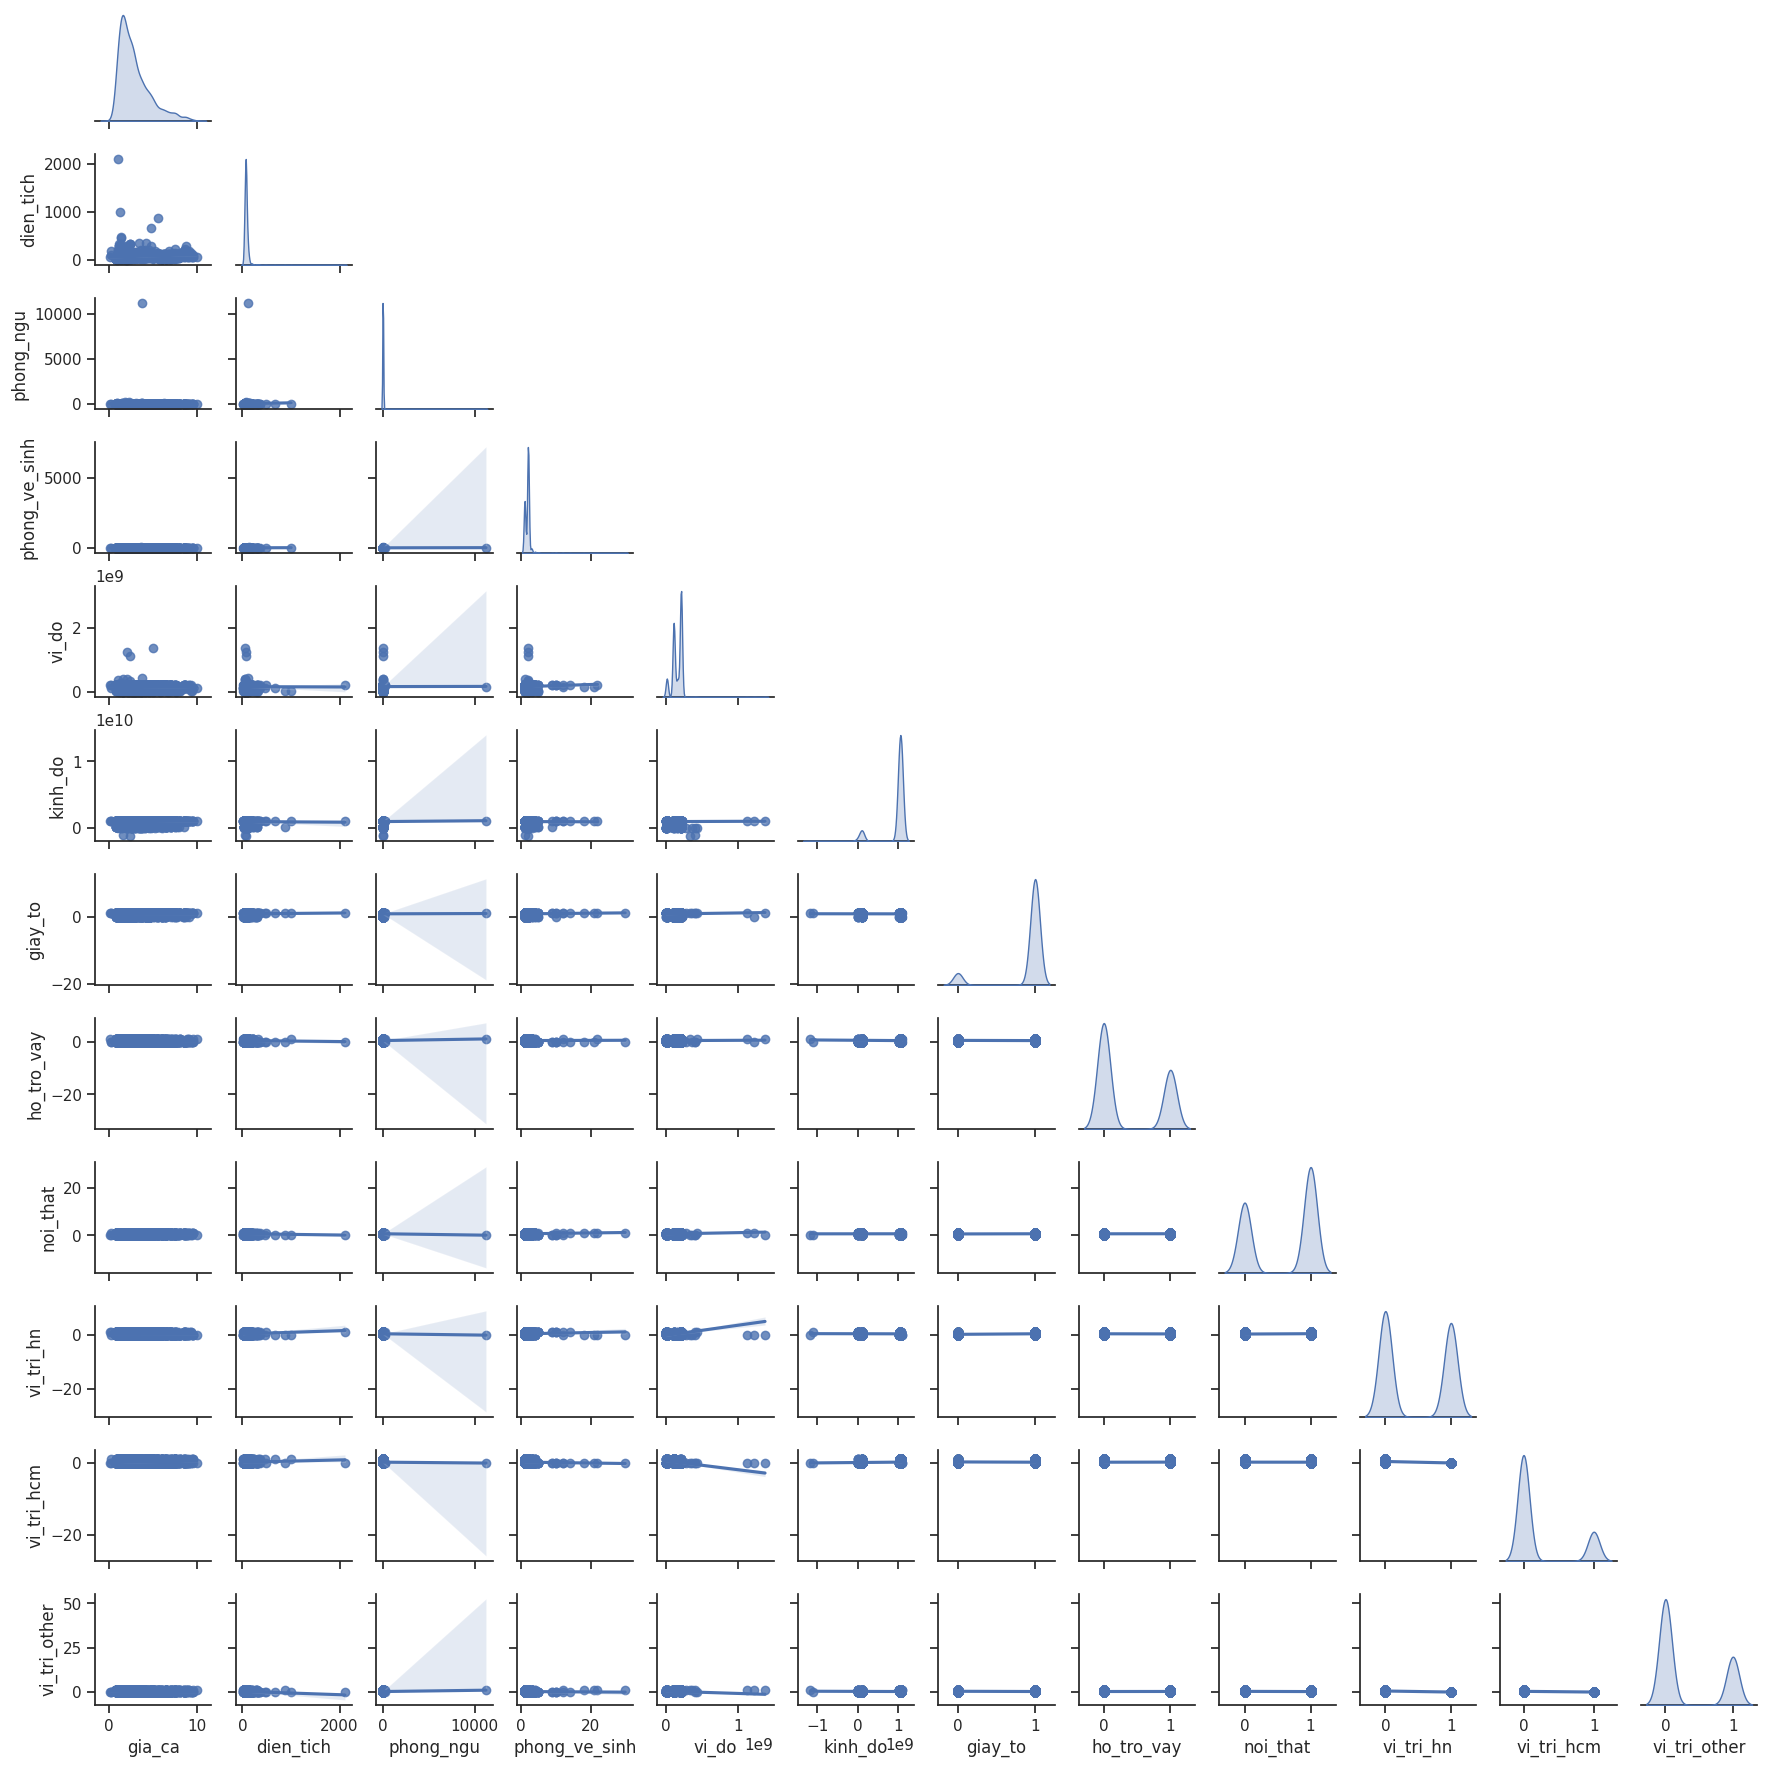

In [160]:
sns.set_theme(style="ticks")
sns.pairplot(df, kind='reg', diag_kind='kde', height=1.5, corner=True)
#fig.savefig('demo.png', bbox_inches='tight')
plt.show()

Kiểm tra kĩ hơn về phân phối của các biến.

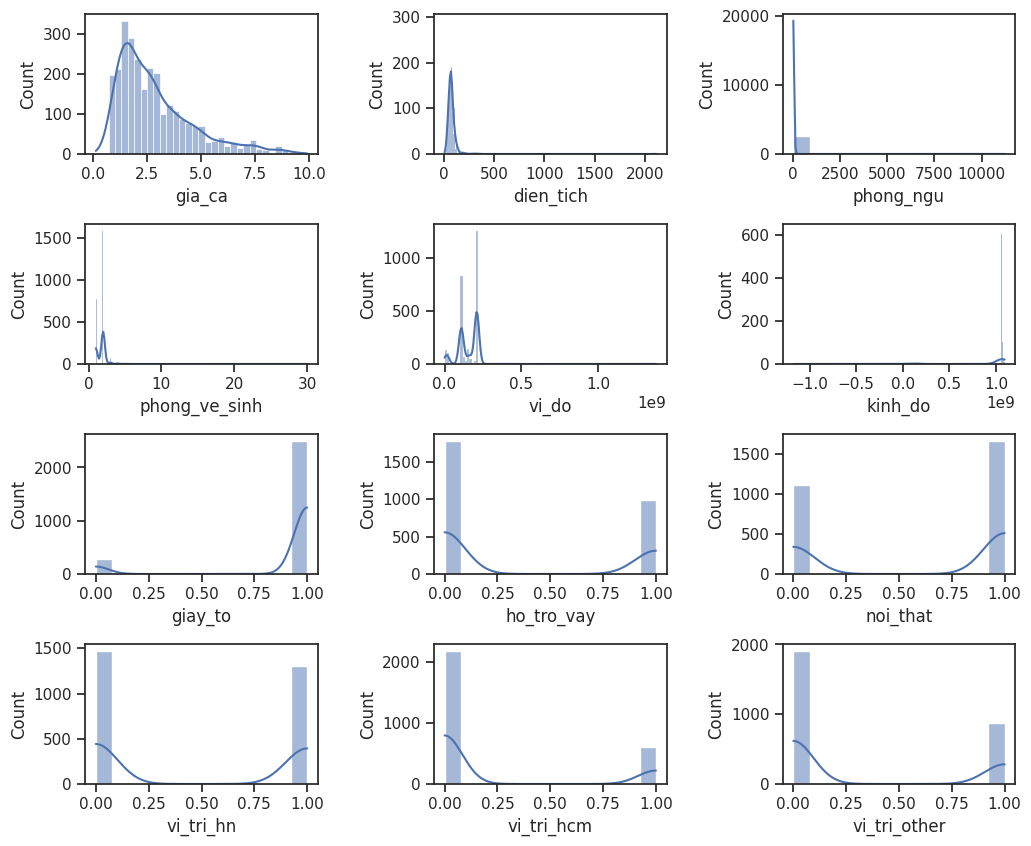

In [161]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(df.columns, 1):
  plt.subplot(4, 3, i)
  plt.subplots_adjust(hspace=0.5, wspace=0.5)
  sns.histplot(df[column], kde=True)
plt.show()

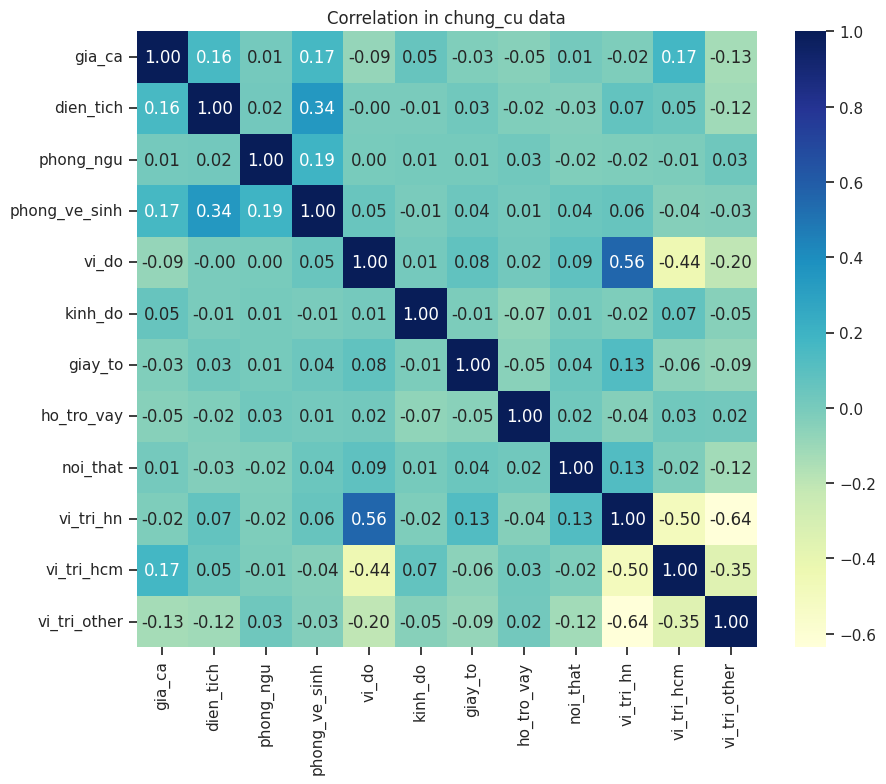

In [162]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap="YlGnBu")
plt.title('Correlation in chung_cu data')
plt.show()

**Nhận xét tổng quan:**

*   Biến 'gia_ca' có khuynh hướng lệch phải, các biến 'dien_tich', 'phong_ngu',  'phong_ve_sinh' và 'vi_do' bị lệch phải rất nặng. Ngoài ra, biến 'kinh_do' bị lệch trái rất nặng. Điều này có thể do các giá trị ngoại lai (outlier) rất lớn tạo ra.
*   Một nửa số biến đều là biến categorical.
*   Khoảng giá trị của các biến không giống nhau.
*   Bởi vì dữ liệu vẫn còn bị khuyết giá trị ở một số biến và bị lệch (skewed) rất nặng nên tương quan giữa các biến như biểu diễn ở trên sẽ có thể thay đổi sau khi xử lý. Ta sẽ quan sát và nhận xét lại sau khi xử lý xong các vấn đề trên.

### Loại bỏ các giá trị ngoại lai (Outlier)

Đối với biến 'phong_ngu' và 'phong_ve_sinh' ta sẽ quan sát số lượng của các giá trị duy nhất và dựa vào sự hợp lý trong thực tế để loại bỏ các giá trị ngoại lai (outlier).

In [163]:
print(df['phong_ngu'].value_counts())
print(df['phong_ve_sinh'].value_counts())

phong_ngu
2.0        1404
1.0         568
3.0         505
4.0          56
13.0         10
5.0           8
23.0          7
123.0         6
10.0          3
12.0          3
11.0          2
40.0          2
30.0          2
17.0          1
32.0          1
25.0          1
14.0          1
223.0         1
234.0         1
11231.0       1
24.0          1
7.0           1
Name: count, dtype: int64
phong_ve_sinh
2.0     1586
1.0      771
3.0       66
4.0       18
5.0        7
10.0       3
12.0       2
9.0        2
30.0       1
21.0       1
18.0       1
14.0       1
22.0       1
Name: count, dtype: int64


Ở đây, ta thấy cả 2 biến đều có hầu hết số lượng đều nằm trong các giá trị từ 1 đến 4. Điều này cũng sát với thực tế vì các chung cư ta thường thấy cũng chỉ có số phòng ngủ, số phòng vệ sinh nằm trong khoảng giá trị này (chỉ trừ một vài "siêu" chung cư có thể có nhiều hơn nhưng không đáng kể).

In [164]:
df = df[df['phong_ngu'] <= 4]
df = df[df['phong_ve_sinh'] <= 4]

Loại bỏ các giá trị ngoại lai bằng IQR.

In [165]:
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[df[col] <= q3 + 1.5 * iqr]
    df = df[df[col] >= q1 - 1.5 * iqr]
    df = df.reset_index(drop=True)
    return df

In [166]:
df = remove_outliers(df, 'dien_tich')
df = remove_outliers(df, 'kinh_do')
df = remove_outliers(df, 'vi_do')

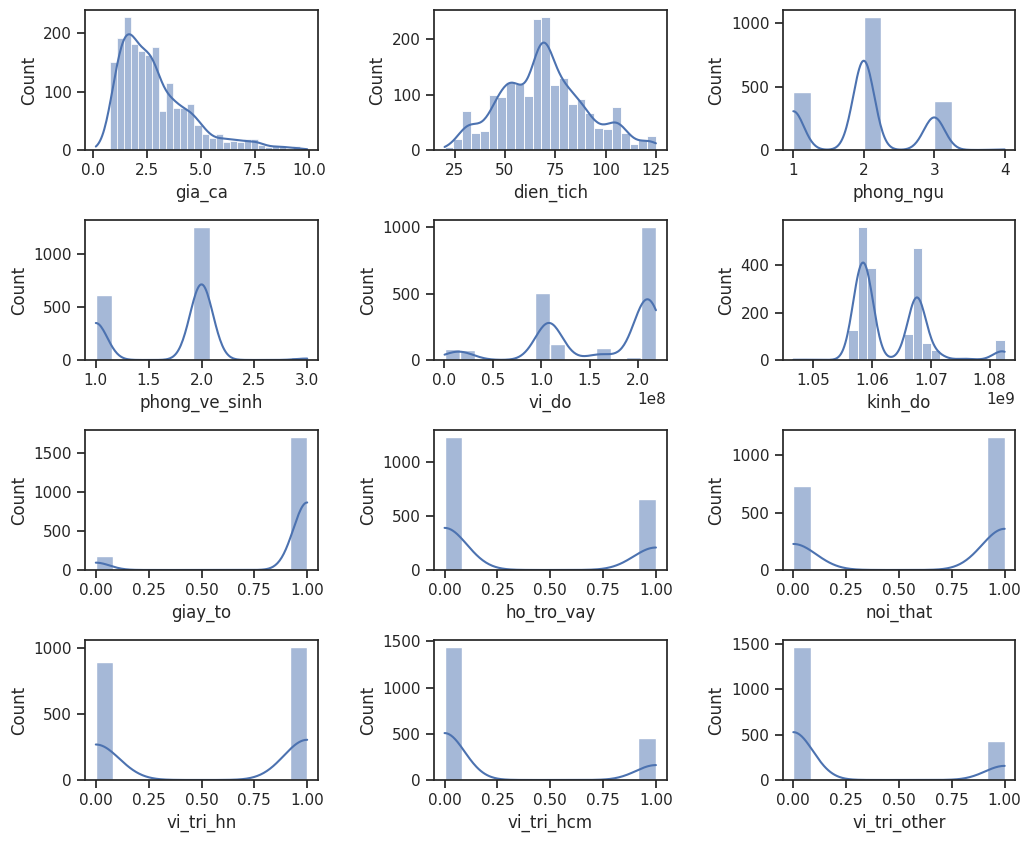

In [167]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(df.columns, 1):
  plt.subplot(4, 3, i)
  plt.subplots_adjust(hspace=0.5, wspace=0.5)
  sns.histplot(df[column], kde=True)
plt.show()

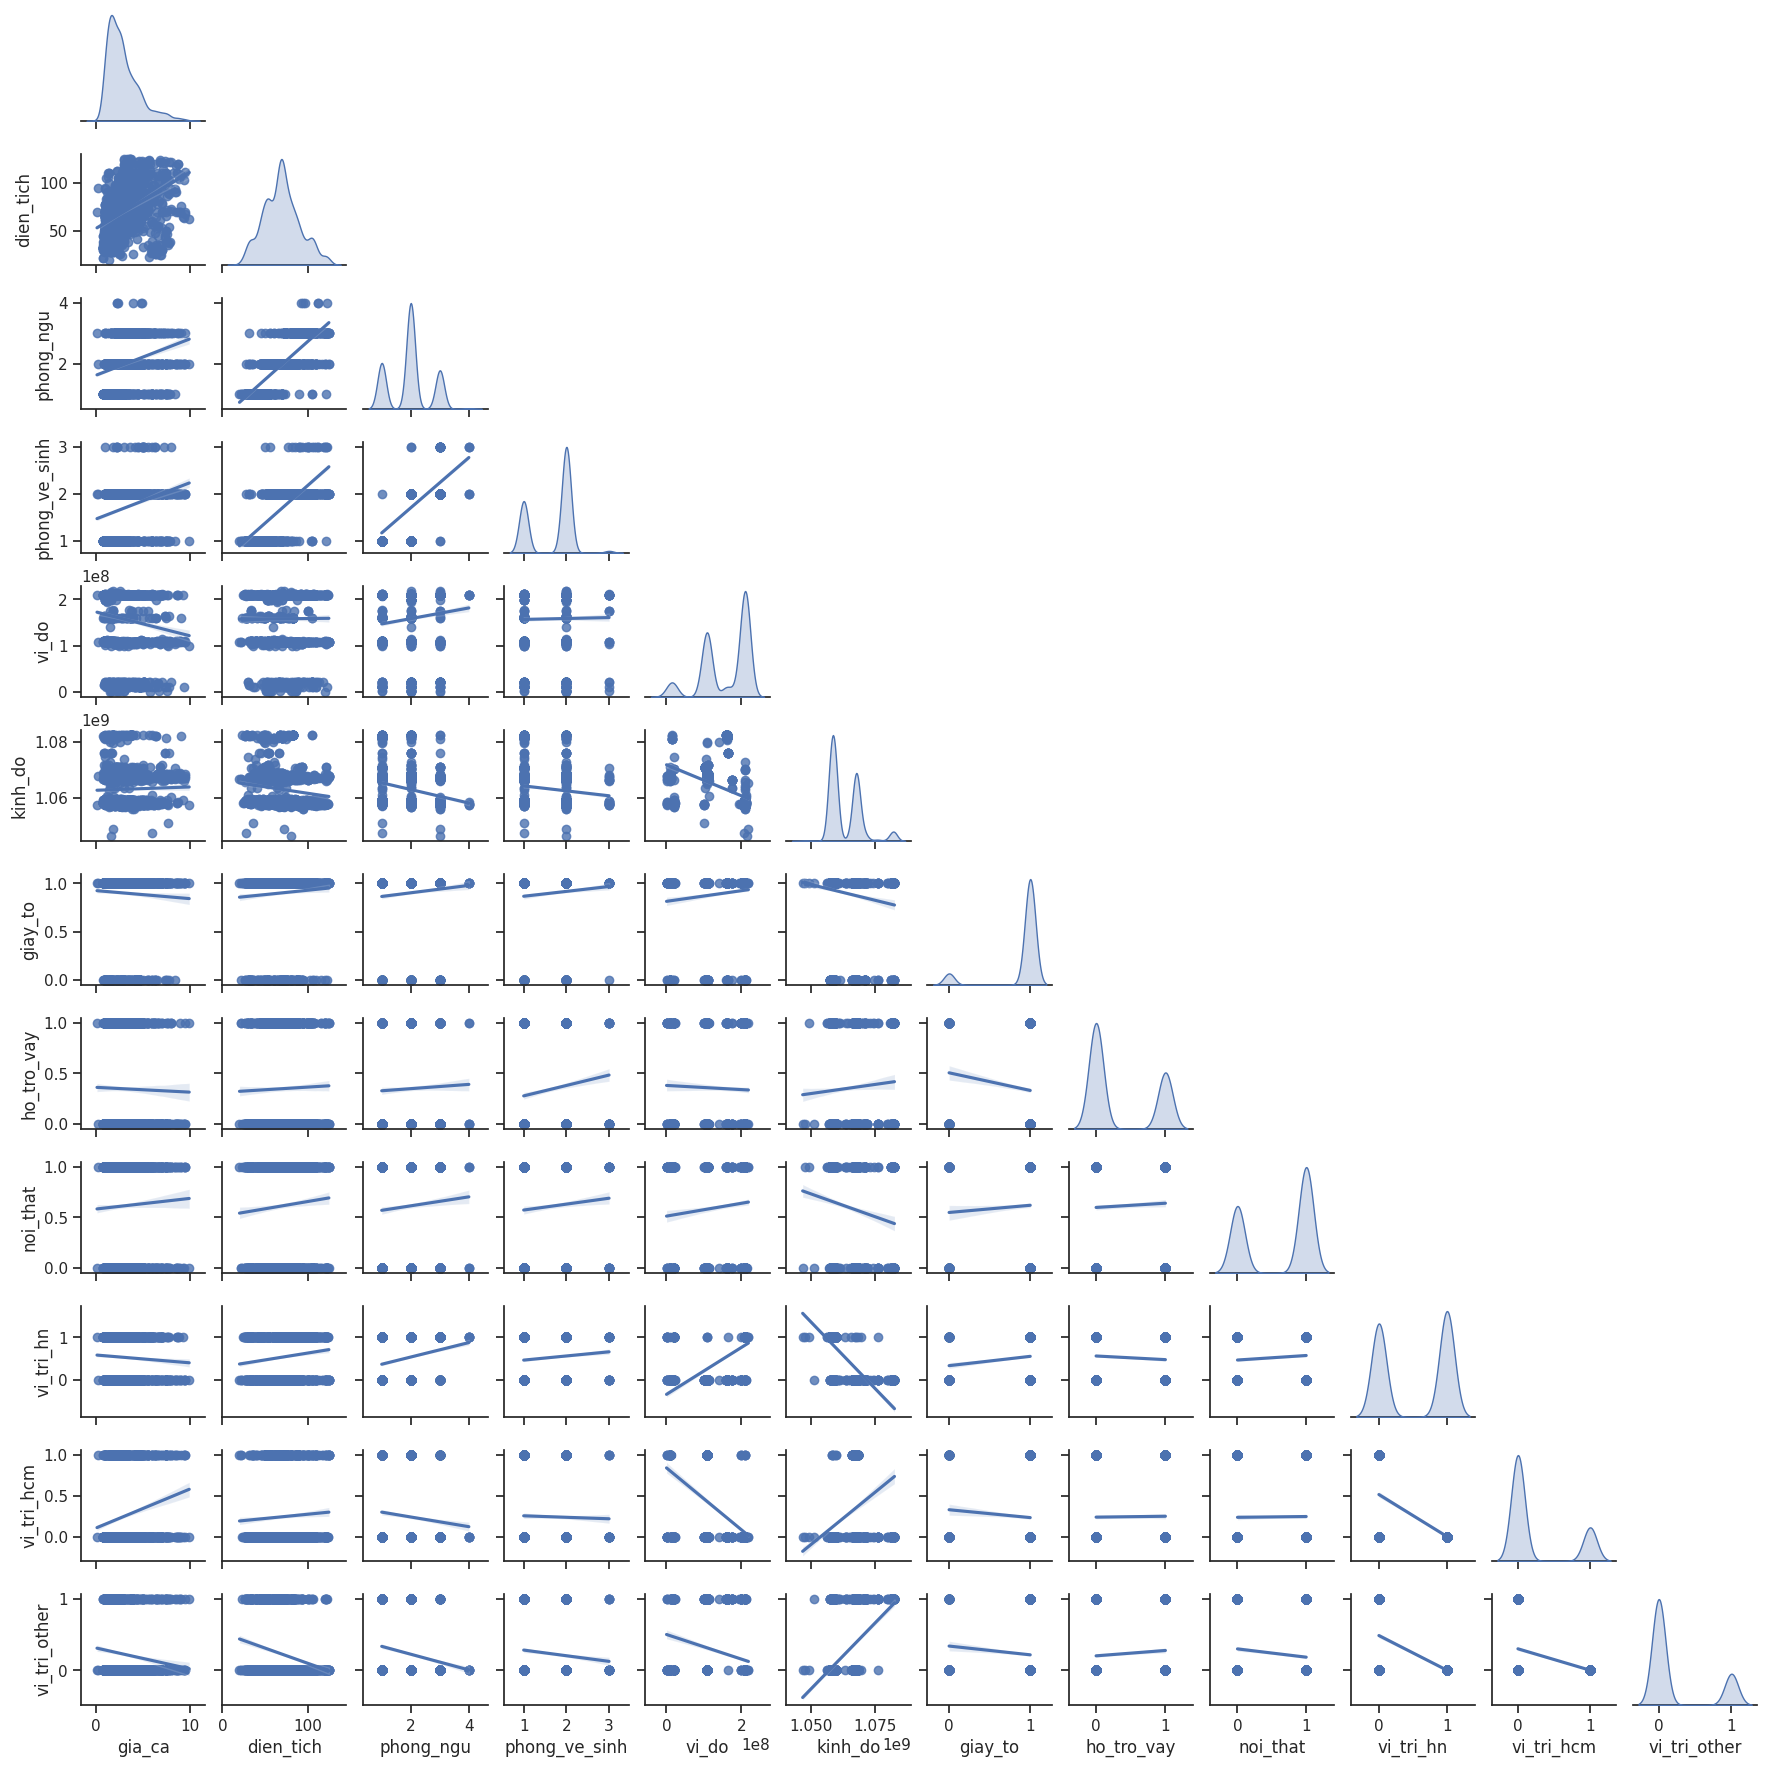

In [168]:
sns.set_theme(style="ticks")
sns.pairplot(df, kind='reg', diag_kind='kde', height=1.5, corner=True)
plt.show()

In [169]:
check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 1900
Columns: 12
------------------------------- TYPES --------------------------------
gia_ca           float64
dien_tich        float64
phong_ngu        float64
phong_ve_sinh    float64
vi_do            float64
kinh_do          float64
giay_to            int64
ho_tro_vay         int64
noi_that           int64
vi_tri_hn          int64
vi_tri_hcm         int64
vi_tri_other       int64
dtype: object
-------------------------------- HEAD --------------------------------
   gia_ca  dien_tich  phong_ngu  phong_ve_sinh        vi_do       kinh_do  \
0    3.30       88.0        3.0            2.0  209589392.0  1.058429e+09   
1    2.60       80.0        3.0            2.0  209997545.0  1.059421e+09   
2    1.40       45.0        1.0            1.0  109570181.0  1.067202e+09   
3    3.45       83.9        3.0            2.0  209997545.0  1.059421e+09   
4    4.00      104.0        2.0            2.0  209589392.0  1.05

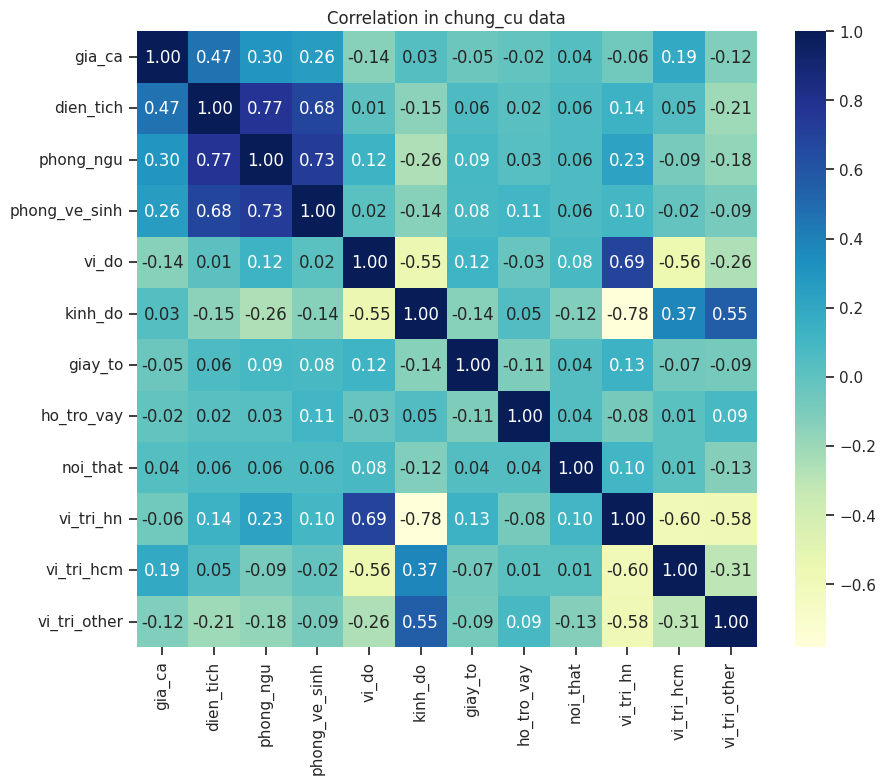

In [170]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap="YlGnBu")
plt.title('Correlation in chung_cu data')
plt.show()

**Nhận xét tổng quan:**

*   Sau khi loại bỏ các biến ngoại lai thì biến 'dien_tich' và 'kinh_do' đã không còn bị lệch; biến 'vi_do' vẫn bị lệch nhẹ; các biến 'gia_ca', 'phong_ngu' và 'phong_ve_sinh' vẫn còn bị lệch phải dù đã đỡ hơn.
*   Sau khi loại bỏ các giá trị ngoại lai, các biến 'phong_ngu' và 'phong_ve_sinh' gần như đã trở thành biến categorical khi chỉ chứa 4 và 3 giá trị duy nhất.
*   Sau khi loại bỏ các giá trị ngoại lai, rất may mắn bộ dữ liệu cũng không còn bị khuyết (missing values). Điều này cho thấy các giá trị bị khuyết đều nằm trong khoảng ngoại lai mà ta đã loại bỏ.
*   Do không còn các giá trị ngoại lai và dữ liệu không còn bị khuyết, ta có thể vẽ biểu đồ thể hiện tương quan giữa các biến và nhận xét.
*   Biến phụ thuộc 'gia_ca' có tương quan thuận mạnh với biến độc lập 'dien_tich'. Điều này là hợp lý vì trên thực tế các chung cư càng có diện tích lớn thì giá của chúng cũng cao hơn.
*   Giữa các biến 'dien_tich', 'phong_ngu' và 'phong_ve_sinh' có mối tương quan thuận mạnh. Điều này là đúng với thực tế vì thường các phòng chung cư có diện tích càng lớn thì số phòng ngủ và phòng vệ sinh cũng càng nhiều. Điều này dễ dẫn tới hiện tượng đa cộng tuyến khi xây dựng mô hình tuyến tính.
*   Biến 'vi_do' có tương quan mạnh với các biến 'vi_tri_hn', 'vi_tri_hcm'. Biến 'kinh_do' có tương quan mạnh với các biến 'vi_tri_hn', 'vi_tri_other'. Điều này là đúng vì kinh độ, vĩ độ biểu diễn vị trí của các chung cư trên bản đồ thế giới nên hiển nhiên các biến này sẽ có tương quan với nhau.
*   Biến 'vi_tri_hn' có tương quan nghịch mạch với biến 'vi_tri_hcm' và 'vi_tri_other'. Điều này là hiển nhiên vì ta đã one hot encode các biến này.

### Biến đổi biến phụ thuộc (Dành riêng cho Linear Regression)


Do biến 'gia_ca' bị lệch phải nhẹ và có khả năng tồn tại mối quan hệ phi tuyến đối với các biến độc lập, ta thêm vào biến biến đổi log(gia_ca).

In [171]:
df['log_gia_ca'] = np.log(df['gia_ca'])

Kiểm tra lại phân phối và mối tương quan của các biến với biến phụ thuộc 'gia_ca' thay thế bởi log(gia_ca)

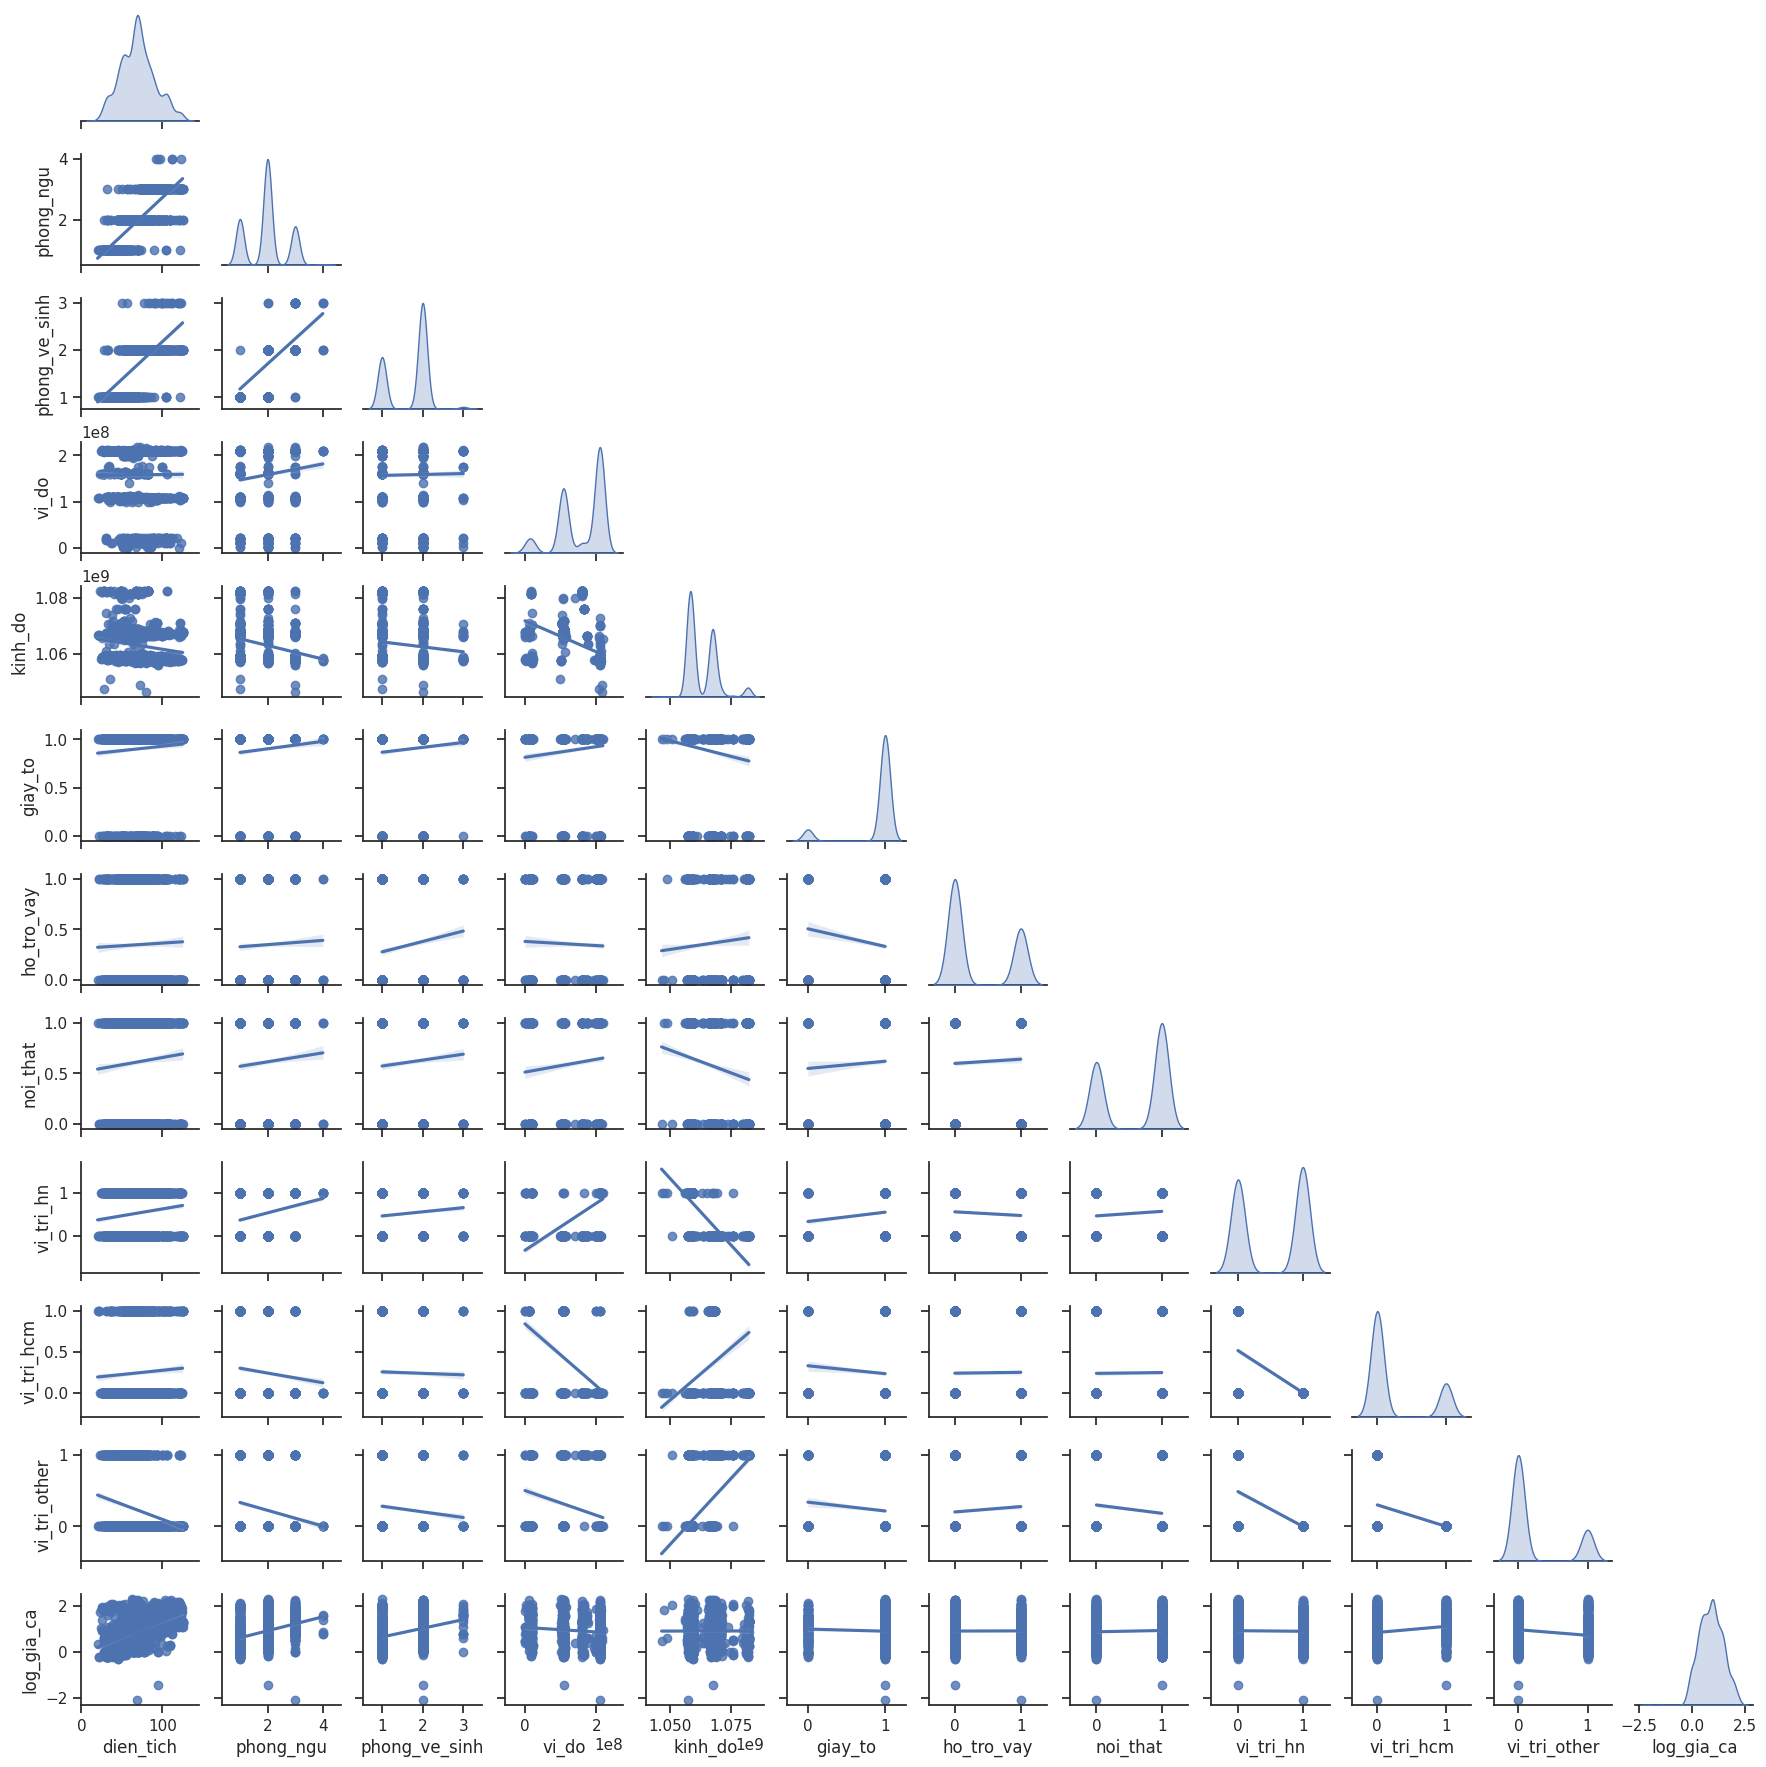

In [172]:
sns.set_theme(style="ticks")
sns.pairplot(df.drop(columns=['gia_ca']), kind='reg', diag_kind='kde', height=1.5, corner=True)
plt.show()

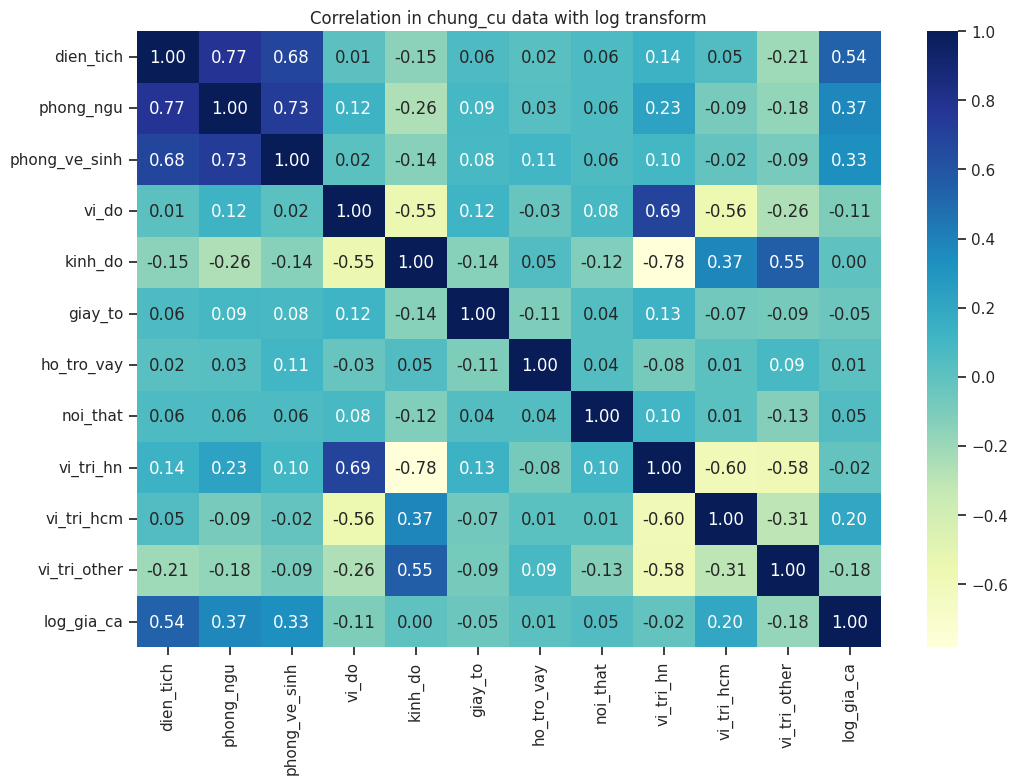

In [173]:
log_corr = df.drop(columns=['gia_ca']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(log_corr, annot=True, fmt='.2f', cmap="YlGnBu")
plt.title('Correlation in chung_cu data with log transform')
plt.show()

**Nhận xét nhanh**:

Ta nhận thấy biến 'log_gia_ca' có mối quan hệ tuyến tính với các biến giải thích cao hơn gia_ca. Đồng thời đảm bảo được 2 điều kiện giả định là:
  1. Điều kiện tuyến tính.
  2. Điều kiện phân phối chuẩn.

Do đó ta có thể xây dựng mô hình tuyến tính dựa trên biến 'logMPG' và các biến còn lại.


### c. Huấn luyện mô hình
Ở phần này, nhóm sẽ huấn luyện và so sánh hiệu quả của 3 mô hình: Linear Regression, Random Forest và Gradient Boosting.

Đặc điểm và hiệu quả của mỗi mô hình:
- Linear Regression:
    + Điểm mạnh: Có tính giải thích cao, nhanh chóng để mô hình hóa và đặc biệt hữu ích khi mối quan hệ được mô hình hóa không quá phức tạp.
    + Điểm yếu: Bị ràng buộc bởi nhiều giả định, chỉ mạnh với các tương quan tuyến tính.
    + Dự đoán hiệu quả: Dựa vào các phân tích ở trên, ta thấy biến phụ thuộc 'gia_ca' chỉ có tương quan thuận mạnh với 1 biến 'dien_tich', các biến độc lập có tương quan mạnh với nhau dẫn tới khả năng đa cộng tuyến cao. Từ đó, ta thấy mô hình Linear Regression có thể sẽ không cho kết quả khả quan với bộ dữ liệu này.
   
- Random Forest:
    + Điểm mạnh: Xử lý được tập dữ liệu lớn và nhiều đặc trưng, vẫn hoạt động được khi dữ liệu bị khuyết, không bị ảnh hưởng bởi tương quan phi tuyến, cải thiện độ chính xác so với mô hình Decision Tree, giảm thiểu vấn đề overfitting.
    + Điểm yếu: Yêu cầu nhiều tài nguyên tính toán hơn và phức tạp hơn, khó giải thích, không phải lúc nào cũng tốt khi sử dụng trong hồi quy.
    + Dự đoán hiệu quả: Dữ liệu có nhiều biến categorical và gặp vấn đề về tương quan mạnh giữa các biến độc lập nhưng mô hình Random Forest không bị ảnh hưởng dẫn tới kết quả có thể sẽ tốt hơn mô hình Linear Regression.
      
- Gradient Boosting:
    + Điểm mạnh: Có thể tối ưu hóa và tùy chỉnh siêu tham số các hàm mất mát (loss function) khác nhau, không cần xử lý dữ liệu trước, xử lý được dữ liệu thiếu, mang lại độ chính xác dự đoán cao.
    + Điểm yếu: Độ phức tạp cao do kết hợp nhiều mô hình con (weak learner), thời gian tính toán lâu, thường được coi là một mô hình hộp đen (black box) có tính giải thích yếu, nhạy cảm với các giá trị ngoại lai và nhiễu (noise), cần các bước xử lý như scaling.
    + Dự đoán hiệu quả: Mô hình chạy được tốt với cả biến liên tục và biến categorical, không bị ảnh hưởng với tương quan phi tuyến và tối ưu hóa các siêu tham số của hàm mất mát nên nhóm dự đoán mô hình Gradient Boosting sẽ cho kết quả tốt với bộ dữ liệu này.

### Chia tập Train-Test

In [174]:
def prepare_X_y(df):
    # Chia dữ liệu thành X (biến độc lập) và y (biến phụ thuộc). Trả về 2 dataframe
    X = df.drop(['gia_ca', 'log_gia_ca'], axis=1) # Chọn các cột chứa feature
    y = df['gia_ca'] # Chọn cột chứa giá trị cần dự đoán
    return X, y

X, y = prepare_X_y(df)
print(X.shape)
print(y.shape)

(1900, 11)
(1900,)


In [175]:
def split_train_test(X, y, train_size=0.8):
    # Dùng hàm train_test_split để chia X và y thành 2 tập: train và test
    # Với train_size là tỉ lệ của tập train và cố định random_state để không bị thay đổi kết quả
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=True, random_state=0)
    print(f"Training set size: \tX_train: {X_train.shape} \tY_train: {y_train.shape}")
    print(f"Testing set size: \tX_test: {X_test.shape} \ty_train: {y_test.shape}")
    return X_train, X_test, y_train, y_test

In [176]:
TRAIN_SIZE = 0.8 # Chọn tỉ lệ tập Train

X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=TRAIN_SIZE)

Training set size: 	X_train: (1520, 11) 	Y_train: (1520,)
Testing set size: 	X_test: (380, 11) 	y_train: (380,)


### Khởi tạo mô hình Linear Regression

In [177]:
def build_linear_model(X, y):
    # X, y nên lấy từ tập Train
    # Tách tên của các biến X, y để viết hàm hồi quy
    X_variable = list(X.columns.values)
    y_variable = y.name
    data = pd.concat([X, y], axis=1, join='inner')
    formula = y_variable + '~' +'+'.join(X_variable)
    # Dùng hàm Ordinary Least Squares regression (OLS) từ sklearn, input là hàm hồi quy (có bias) và dữ liệu của các biến (X, y)
    model = smf.ols(formula=formula, data=data)
    # Fit/Train model
    results = model.fit()
    return results

# Huấn luyện mô hình với tập Train
model = build_linear_model(X_train, y_train)

In [178]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 gia_ca   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     50.17
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           4.71e-87
Time:                        16:28:05   Log-Likelihood:                -2735.0
No. Observations:                1520   AIC:                             5492.
Df Residuals:                    1509   BIC:                             5551.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.6786      7.962      0.462      0.644     -11.939      19.296
dien_tich         0.0432      0.003     14.290      0.000       0.037       0.049
phong_ngu        -0.0984      0.102     -0.965      0.334      -0.298       0.102
phong_ve_sinh    -0.2321      0.119     -1.952      0.051      -0.465       0.001
vi_do          -1.73e-09    8.6e-10     -2.011      0.044   -3.42e-09   -4.28e-11
kinh_do       -3.546e-09   9.94e-09     -0.357      0.721    -2.3e-08     1.6e-08
giay_to          -0.3364      0.130     -2.596      0.010      -0.591      -0.082
ho_tro_vay       -0.1197      0.081     -1.487      0.137      -0.278       0.038
noi_that          0.0110      0.079      0.140      0.889      -0.144       0.166
vi_tri_hn         1.0522      2.593      0.406      0.685      -4.034       6.139
vi_tri_hcm        1.5378      2.673      0.575      0.565      -3.705       6.780
vi_tri_other      1.0886      2.699      0.403      0.687      -4.206       6.383
==============================================================================
Omnibus:                      599.619   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2482.757
Skew:                           1.887   Prob(JB):                         0.00
Kurtosis:                       7.997   Cond. No.                     8.75e+23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.29e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

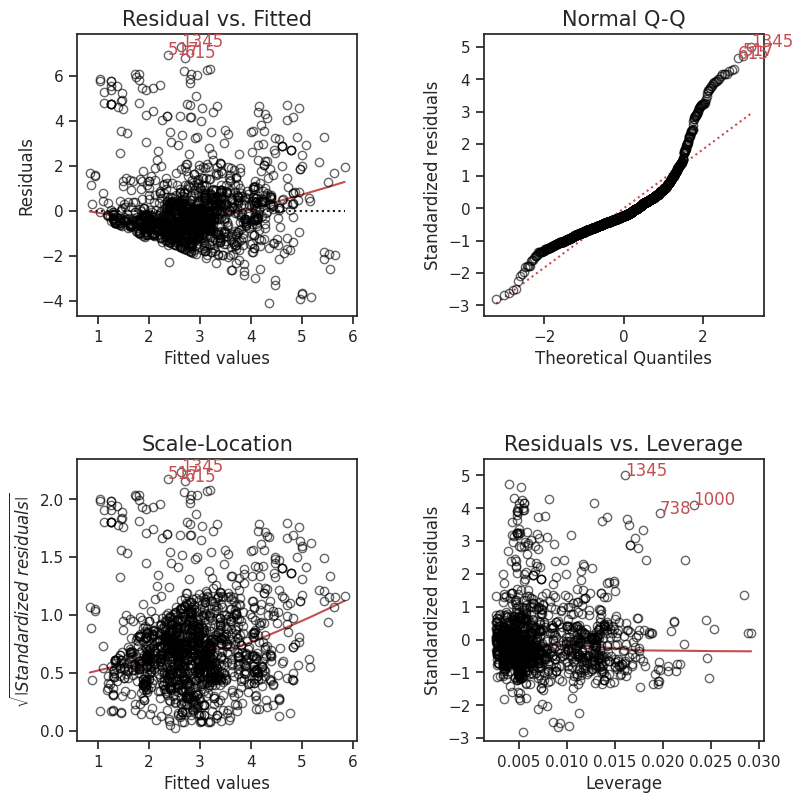

In [179]:
plt.figure(figsize=(8, 8))
lmdiag.plot(model)

In [180]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [181]:
calculate_vif(X_train)

Feature           VIF
0       dien_tich      2.779738
1       phong_ngu      3.293195
2   phong_ve_sinh      2.371361
3           vi_do      2.054737
4         kinh_do      2.819916
5         giay_to      1.041139
6      ho_tro_vay      1.048780
7        noi_that      1.031870
8       vi_tri_hn  41755.879177
9      vi_tri_hcm  19409.712541
10   vi_tri_other  18030.643712

**Nhận xét tổng quan:**

*   Điểm VIF của các biến 'vi_tri_hn', 'vi_tri_hcm' và 'vi_tri_other' lớn hơn 5 rất nhiều cho thấy đã xảy ra đa cộng tuyến (hiện tượng phụ thuộc tuyến tính) giữa các biến dự đoán (X). Điều này vi phạm giả định các biến dự đoán phải độc lập tuyến tính với nhau.
*   Trên biểu đồ "Residual vs. Fitted" ta thấy các điểm phía bên trái bị co cụm ở dưới đường fitted và phân tán rất rộng ở trên đường fitted (Trong khi phải phân tán đều, ngẫu nhiên trên dưới trục Residual = 0). Ngoài ra, trên biểu đồ "Scale-Location" ta thấy đường màu đỏ cong lên trên khi đi dần qua phải cho thấy phương sai của Residual (thặng dư) không phải là hằng số. Điều này cho thấy có thể tồn tại tương quan phi tuyến giữa các biến dự đoán (X) và biến phụ thuộc (Y hay giá nhà). Đồng thời, vi phạm giả định phương sai bằng nhau của mô hình hồi quy tuyến tính.
*   Trên biểu đồ "Normal Q-Q" ta thấy các điểm không nằm dọc trên 1 đường chéo mà lệch ra khỏi đường chéo đó. Điều này cho thấy các Residuals không tuân theo phân phối chuẩn (Giả định phân phối chuẩn của phần dư (Residuals) bị vi phạm).
*   Trên biểu đồ "Residuals vs. Leverage" ta thấy không còn các giá trị ngoại lai (outlier).

Chỉnh sửa mô hình Linear Regression.


In [182]:
y_log = df['log_gia_ca']
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, train_size=0.8, shuffle=True, random_state=0)

In [183]:
def standardize(x):
    y = x - x.mean()
    sd = x.std()
    return y / sd, sd, x.mean()

In [184]:
y_train_log, y_sd, y_mean = standardize(y_train_log)
X_train_log, X_sd, X_mean = standardize(X_train_log)
X_test_log = (X_test_log - X_mean) / X_sd
train_set = pd.concat([X_train_log, y_train_log], axis=1, join='inner')

Để giảm độ phức tạp của mô hình, ta loại những biến độc lập gần như không có tương quan với biến 'log_gia_ca' như các biến 'kinh_do', 'giay_to', ho_tro_vay', 'noi_that', 'vi_tri_hn'.

In [185]:
model = smf.ols(formula='log_gia_ca~dien_tich+phong_ngu+phong_ve_sinh+vi_do+vi_tri_hcm+vi_tri_other', data=train_set)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_gia_ca   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     113.3
Date:                Fri, 21 Jun 2024   Prob (F-statistic):          3.27e-118
Time:                        16:28:20   Log-Likelihood:                -1874.2
No. Observations:                1520   AIC:                             3762.
Df Residuals:                    1513   BIC:                             3800.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.214e-16      0.021  -5.69e-15      1.000      -0.042       0.042
dien_tich         0.5511      0.036     15.517      0.000       0.481       0.621
phong_ngu        -0.0211      0.039     -0.547      0.584      -0.097       0.055
phong_ve_sinh    -0.0409      0.033     -1.254      0.210      -0.105       0.023
vi_do            -0.0475      0.030     -1.562      0.119      -0.107       0.012
vi_tri_hcm        0.1340      0.031      4.305      0.000       0.073       0.195
vi_tri_other     -0.0464      0.027     -1.707      0.088      -0.100       0.007
==============================================================================
Omnibus:                      176.150   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              854.269
Skew:                           0.435   Prob(JB):                    3.15e-186
Kurtosis:                       6.568   Cond. No.                         3.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

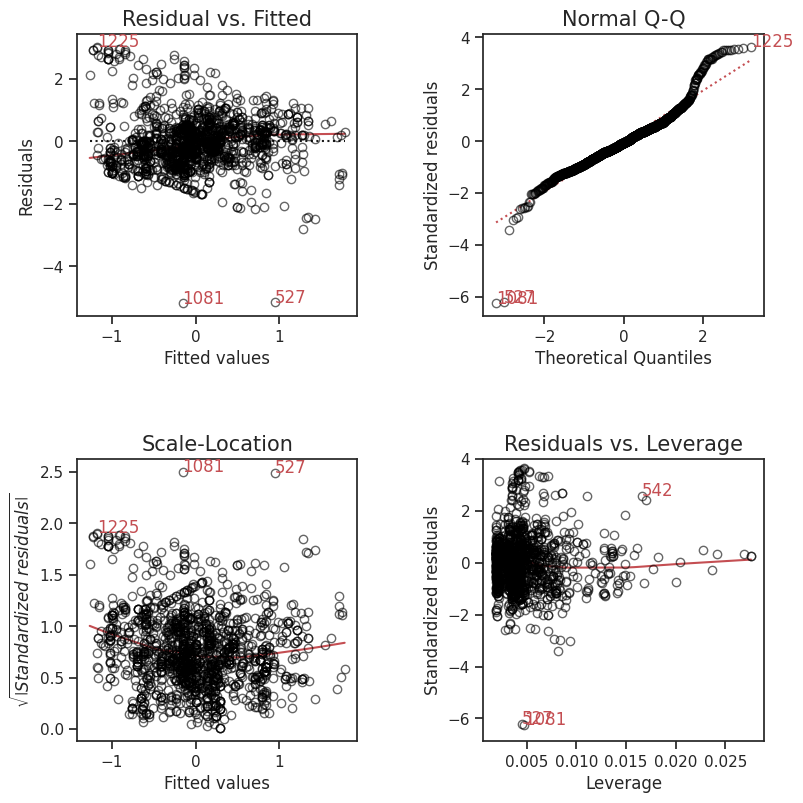

In [186]:
plt.figure(figsize=(8, 8))
lmdiag.plot(results)

In [187]:
X = train_set.drop(['log_gia_ca', 'giay_to', 'ho_tro_vay', 'noi_that', 'vi_tri_hn', 'kinh_do'], axis=1)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

         Feature       VIF
0      dien_tich  2.765646
1      phong_ngu  3.257838
2  phong_ve_sinh  2.328231
3          vi_do  2.029377
4     vi_tri_hcm  2.124797
5   vi_tri_other  1.620914


In [188]:
# Tính toán trên tập huấn luyện
y_train_pred = results.predict(X_train_log)
y_train_pred = y_train_pred * y_sd + y_mean
y_train_log = y_train_log * y_sd + y_mean
r2_train_lr = r2_score(y_train_log, y_train_pred)
mse_train_lr = mean_squared_error(y_train_log, y_train_pred)

# Tính toán trên tập kiểm tra
y_test_pred = results.predict(X_test_log)
y_test_pred = y_test_pred * y_sd + y_mean
y_test_log = y_test_log * y_sd + y_mean
r2_test_lr = r2_score(y_test_log, y_test_pred)
mse_test_lr = mean_squared_error(y_test_log, y_test_pred)

print(f"Train R²: {r2_train_lr} \tTrain MSE: {mse_train_lr}")
print(f"Test R²: {r2_test_lr} \tTest MSE: {mse_test_lr}")

Train R²: 0.31004018925077215 	Train MSE: 0.21442969048118027
Test R²: -2.6830503025773558 	Test MSE: 0.33820880772593725


**Nhận xét tổng quan:**

*   Mô hình giải thích được 30.7% ý nghĩa của biến 'log_gia_ca'. Tuy vẫn thấp và không đủ tin cậy để sủ dụng nhưng vẫn đã cao hơn so với trước.
*   Điểm R² của mô hình bị âm, cho thấy khả năng dự đoán của mô hình còn kém hơn khả năng dự đoán của giá trị trung bình của 'log_gia_ca'. Ngoài ra, điểm R² của tập Train cũng thấp. Điều này cho thấy mô hình không giải thích tốt sự biến thiên của bộ dữ liệu. Điểm MSE của mô hình trong cả 2 tập đều nhỏ, điều này cho thấy mô hình có khả năng dự đoán tốt nhưng lại không thể giải thích được tại sao kết quả đó lại tốt.
*   R²_test << R²_train chứng tỏ là mô hình không khái quát được tốt.
*   Điểm VIF của các biến độc lập đều nhỏ hơn 5 cho thấy ta đã loại bỏ được hiện tượng đa cộng tuyến (hiện tượng phụ thuộc tuyến tính) giữa các biến dự đoán (X).
*   Trên biểu đồ "Residual vs. Fitted" ta thấy các điểm tuy đã phân tán đều, ngẫu nhiên hơn nhưng vẫn có dấu hiện phân bố nhiều ở góc trên bên trái và góc dưới bên phải của đường fitted.
*   Trên biểu đồ "Scale-Location" ta thấy đường màu đỏ đã giảm độ cong và nằm ngang nhiều hơn cho thấy phương sai của Residual (thặng dư) đã gần bằng nhau hơn.
*   Trên biểu đồ "Normal Q-Q" ta thấy hầu hết các điểm đều nằm dọc trên 1 đường chéo, chỉ duy có các điểm ở phía trên bị lệch ra.
*   Trên biểu đồ "Residuals vs. Leverage" ta thấy không còn các giá trị ngoại lai (outlier).

**Kiểm tra các giả định:**

Từ phân tích trên, ta thấy ta đã đảm bảo mô hình thỏa các giả định:
1. Tuyến tính. (Do việc lấy log(gia_ca) trước khi hồi quy)
2. Sai số phân phối chuẩn (Do việc chuẩn hóa gia_ca bằng log(gia_ca))

Ở giả định phương sai bằng nhau, ta thấy rằng sai số phân bố tập trung quanh giá trị 0 với phương sai gần bị lệch nhau nhẹ ở 2 phía trái và phải.

Ở giả định sai số độc lập, log(gia_ca) vẫn vạch ra một đường parabole có độ dốc bé. Mặc dù độ dốc này đã được cải thiện nhiều hơn so với gia_ca. Để thực hiện dự đoán, ta cần phải đưa qua hàm exp, dẫn đến vấn đề variance tăng theo độ lớn của giá trị được fit vẫn chưa được giải quyết triệt để.

Ghi chú: Giữa các biến có sự đa cộng tuyến cao.


**Nêu ý nghĩa mô hình:**

+ Mô hình được chọn là gia_ca ~ exp(0.5511.dien_tich - 0.0211.phong_ngu - 0.0409.phong_ve_sinh - 0.0475.vi_do + 0.1340.vi_tri_hcm - 0.0464.vi_tri_other).

+ Chỉ có mô hình, biến 'dien_tich' và 'vi_tri_hcm' có mức ý nghĩa bé hơn 0.05.

**Kết luận:**

Từ các nhận xét ở trên, ta thấy mô hình hồi quy tuyến tính ban đầu bị:
*   Vi phạm 3 giả định về phương sai bằng nhau, sai số phân phối chuẩn và sai số độc lập.
*   Đa cộng tuyến nặng.
*   Có thể tồn tại mối tương quan phi tuyến giữa các biến độc lập.

Sau khi chỉnh sửa, ta đã giảm được hiệu ứng của các vi phạm giả định và sự đa cộng tuyến. Tuy nhiên, nếu xem xét khắt khe, mô hình vẫn không thỏa được các giả định, đồng thời hiệu quả cũng vô cùng kém, không thể sử dụng được.

Tất cả điều trên cho thấy mô hình hồi quy tuyến tính không phù hợp với bộ dữ liệu này đúng với dự đoán ban đầu của nhóm.

### Khởi tạo mô hình Random Forest

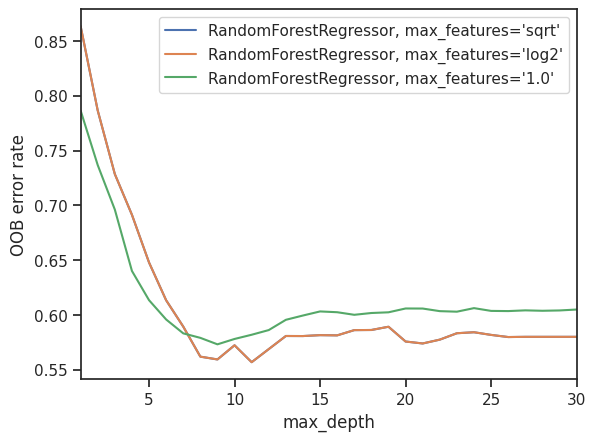

In [189]:
ensemble_regr = [
    (
        "RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(
            oob_score=True,
            max_features="sqrt",
            random_state=0,
        ),
    ),
    (
        "RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(
            max_features="log2",
            oob_score=True,
            random_state=0,
        ),
    ),
    (
        "RandomForestRegressor, max_features='1.0'",
        RandomForestRegressor(
            max_features=1.0,
            oob_score=True,
            random_state=0,
        ),
    ),
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_regr)

min_depth = 1
max_depth = 30
min_error = float("inf")
best_depth = None

for label, regr in ensemble_regr:
    for i in range(min_depth, max_depth + 1, 1):
        regr.set_params(max_depth=i)
        regr.fit(X_train, y_train)

        # Lưu lại OOB error với mỗi max_depth=i
        oob_error = 1 - regr.oob_score_
        error_rate[label].append((i, oob_error))
        if oob_error < min_error:
            min_error = oob_error
            best_depth = i

# Trực quan hóa "OOB error rate" theo "max_depth"
for label, regr_err in error_rate.items():
    xs, ys = zip(*regr_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_depth, max_depth)
plt.xlabel("max_depth")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [190]:
print(f"Best max_depth: {best_depth}, with OOB error: {min_error}")

Best max_depth: 11, with OOB error: 0.5568608665132886


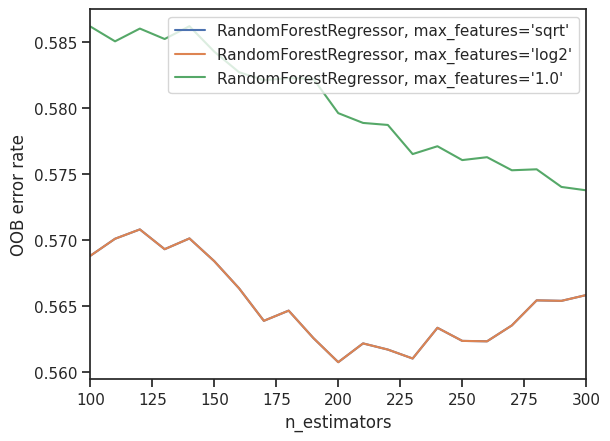

In [191]:
ensemble_regr = [
    (
        "RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(
            oob_score=True,
            max_features="sqrt",
            max_depth = 12,
            random_state=0,
        ),
    ),
    (
        "RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(
            max_features="log2",
            oob_score=True,
            max_depth = 12,
            random_state=0,
        ),
    ),
    (
        "RandomForestRegressor, max_features='1.0'",
        RandomForestRegressor(
            max_features=1.0,
            oob_score=True,
            max_depth = 12,
            random_state=0,
        ),
    ),
]


error_rate = OrderedDict((label, []) for label, _ in ensemble_regr)

min_estimators = 100
max_estimators = 300
min_error = float("inf")
best_estimators = 0

for label, regr in ensemble_regr:
    for i in range(min_estimators, max_estimators + 1, 10):
        regr.set_params(n_estimators=i)
        regr.fit(X_train, y_train)

        # Lưu lại OOB error với mỗi n_estimators=i
        oob_error = 1 - regr.oob_score_
        error_rate[label].append((i, oob_error))
        if oob_error < min_error:
            min_error = oob_error
            best_estimators = i

# Trực quan hóa "OOB error rate" theo "n_estimators"
for label, regr_err in error_rate.items():
    xs, ys = zip(*regr_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [192]:
print(f"Best n_estimators: {best_estimators}, with OOB error: {min_error}")

Best n_estimators: 200, with OOB error: 0.5607591638244613


**Nhận xét nhanh:**

Từ 2 biểu đồ trên, ta thấy đường cho Out-of-bags error rate nhỏ nhất là đường max_features='log2' với các siêu tham số max_depth=11 và n_estimators=200. Do vậy, ta chọn siêu tham số cho mô hình Random Forest Regressor tương ứng như trên.

In [193]:
regr = RandomForestRegressor(
    max_depth=11,
    n_estimators=200,
    max_features='log2',
    random_state=0,
    oob_score=True
)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [194]:
# Tính toán trên tập huấn luyện
y_train_pred = regr.predict(X_train)
r2_train_regr = r2_score(y_train, y_train_pred)
mse_train_regr = mean_squared_error(y_train, y_train_pred)

# Tính toán trên tập kiểm tra
y_test_pred = regr.predict(X_test)
r2_test_regr = r2_score(y_test, y_test_pred)
mse_test_regr = mean_squared_error(y_test, y_test_pred)

print("Out-of-bags score: ", regr.oob_score_)
print(f"Train R²: {r2_train_regr} \tTrain MSE: {mse_train_regr}")
print(f"Test R²: {r2_test_regr} \tTest MSE: {mse_test_regr}")

Out-of-bags score:  0.44433400125486944
Train R²: 0.8088072289072894 	Train MSE: 0.5451918436251235
Test R²: 0.5240137344436224 	Test MSE: 1.221149710453986


Trực quan hóa kết quả dự đoán trên tập Test.

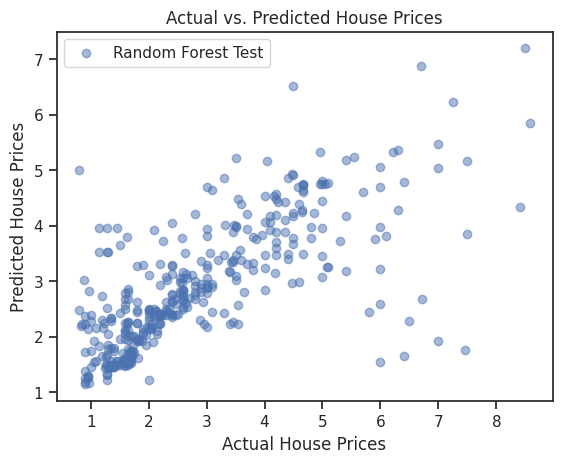

In [195]:
plt.scatter(y_test, y_test_pred, label='Random Forest Test', alpha=0.5)
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Actual vs. Predicted House Prices')
plt.legend()
plt.show()

**Nhận xét tổng quan:**

*   Điểm R² và MSE của mô hình ở tập Train và tập Test đều tốt. Điều này cho thấy mô hình đã giải thích được khá tốt sự biến thiên của bộ dữ liệu này.
*   Điểm metrics của tập Train cách xa điểm metrics của tập Test, đồng thời Out-of-bags score của mô hình cũng khá thấp cho thấy mô hình có khả năng đã bị overfit dù đã hiệu chỉnh các siêu tham số.
*   Nguyên nhân dẫn tới overfit có thể do:
    + Mô hình có các biến liên tục vốn không phù hợp để sử dụng trong Random Forest, các cây có thể đã chia quá chi tiết với các biến này làm cho mô hình bị overfit.
    + Hypertuning chưa đủ.
    + Lượng dữ liệu cho mô hình học chưa đủ lớn để có thể trích ra những đặc điểm quan trọng.


**Kết luận:**

Từ các nhận xét ở trên, ta thấy mô hình Random Forest bị Overfitting mặc dù đã có các bước hiệu chỉnh siêu tham số ở trước đó. Điều này cho thấy các mô hình Random Forest rất sẽ xảy ra Overfitting.

Hướng giải quyết cho vấn đề này có thể là:
*   Hiệu chỉnh thêm các siêu tham số chưa hiệu chỉnh
*   Thu thập thêm dữ liệu để mô hình có thể khái quát hóa các feature tốt hơn
*   Áp dụng thêm regularization vào mô hình như Ridge hay Lasso

Tuy chưa cho ra kết quả xuất sắc nhưng mô hình Random Forest đã cho thấy một kết quả hơn hẳn mô hình Linear Regression. Điều này cho thấy mô hình Random Forest phù hợp với bộ dữ liệu này hơn Linear Regression (đúng với dự đoán ban đầu của nhóm).

### Khởi tạo mô hình Gradient Boosting

In [196]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [197]:
model = GradientBoostingRegressor()
model.fit(X_train,y_train.ravel())
y_pred_model = model.predict(X_test)

In [198]:
# Tính toán trên tập huấn luyện
y_train_pred = model.predict(X_train)
r2_train_gb = r2_score(y_train, y_train_pred)
mse_train_gb = mean_squared_error(y_train, y_train_pred)

# Tính toán trên tập kiểm tra
y_test_pred = model.predict(X_test)
r2_test_gb = r2_score(y_test, y_test_pred)
mse_test_gb = mean_squared_error(y_test, y_test_pred)

print(f"Train R²: {r2_train_gb} \tTrain MSE: {mse_train_gb}")
print(f"Test R²: {r2_test_gb} \tTest MSE: {mse_test_gb}")

Train R²: 0.5999238386872598 	Train MSE: 1.1408290111072668
Test R²: 0.4822805148746848 	Test MSE: 1.3282168942798702


Hiệu chỉnh các siêu tham số (hypertuning).

In [199]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9]
}

grid_search = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train.ravel())

best_model = grid_search.best_estimator_

In [200]:
# Tính toán trên tập huấn luyện
y_train_pred = best_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

# Tính toán trên tập kiểm tra
y_test_pred = best_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Train R²: {r2_train} \tTrain MSE: {mse_train}")
print(f"Test R²: {r2_test} \tTest MSE: {mse_test}")

Train R²: 0.7435725200244099 	Train MSE: 0.7312105461154982
Test R²: 0.5163986440180183 	Test MSE: 1.2406863360695124


Trực quan hóa kết quả dự đoán trên tập Test.

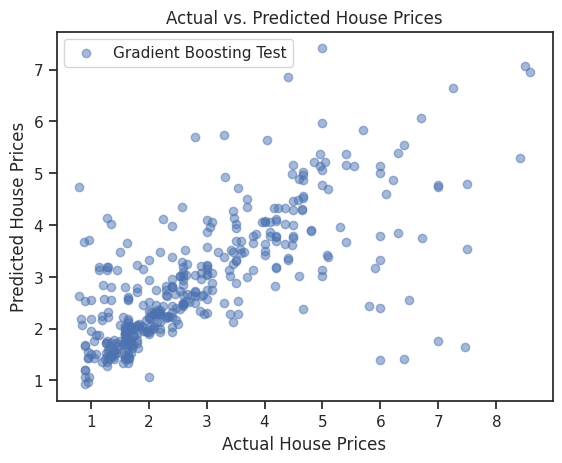

In [201]:
plt.scatter(y_test, y_test_pred, label='Gradient Boosting Test', alpha=0.5)
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Actual vs. Predicted House Prices')
plt.legend()
plt.show()

**Nhận xét tổng quan:**

*   Điểm R² và MSE của mô hình trước khi hiệu chỉnh siêu tham số ở tập Train và tập Test đều tốt. Điều này cho thấy mô hình đã giải thích được khá tốt sự biến thiên của bộ dữ liệu này.
*   Điểm metrics của tập Train và tập Test cách nhau không quá xa, không có dấu hiệu rõ ràng của overfitting.
*   So với 2 mô hình trên, mô hình Gradient Boosting cho ra kết quả khả quan nhất vì cho ra điểm R² và MSE rất gần với mô hình Random Forest nhưng lại không có dấu hiệu overfitting.
*   Tuy nhiên, sau khi tự hiệu chỉnh siêu tham số, mô hình đã có dấu hiệu của overfitting (Các điểm metrics của tập Train và tập Test cách nhau khá xa).


**Kết luận:**

Từ các nhận xét ở trên, ta thấy mô hình Gradient Boosting ban đầu không bị Overfitting. Trong khi đó mô hình sau khi hiệu chỉnh siêu tham số lại bị Overfitting. Vì vậy, mô hình tốt nhất của phương pháp Gradient Boosting chính là mô hình ban đầu.

Nguyên nhân dẫn tới Overfitting ở mô hình sau khi hiệu chỉnh siêu tham số có thể là:
*   Phương pháp hiệu chỉnh không đúng kỹ thuật. Điều này nhóm không có kinh nghiệm nên cũng đã lường trước được.

Hướng giải quyết cho vấn đề này có thể là:
*   Hiệu chỉnh đúng phương pháp
*   Thu thập thêm dữ liệu để mô hình có thể khái quát hóa các feature tốt hơn
*   Áp dụng thêm regularization vào mô hình như Ridge hay Lasso

Với việc cho ra kết quả khả quan cộng với việc mô hình Gradient Boosting còn không bị overfitting đã cho thấy mô hình Gradient Boosting là phù hợp với bộ dữ liệu này (đúng với dự đoán ban đầu của nhóm).

### So sánh giữa các mô hình

In [202]:
# Tính toán MSE và R2
results = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'Train MSE': [
        mse_train_lr,
        mse_train_regr,
        mse_train_gb
    ],
    'Train R2': [
        r2_train_lr,
        r2_train_regr,
        r2_train_gb
    ],
    'Test MSE': [
        mse_test_lr,
        mse_test_regr,
        mse_test_gb
    ],
    'Test R2': [
        r2_test_lr,
        r2_test_regr,
        r2_test_gb
    ]
}

datadf = pd.DataFrame(results)
datadf.set_index('Model', inplace=True)
datadf

Train MSE  Train R2  Test MSE   Test R2
Model                                                     
Linear Regression   0.214430  0.310040  0.338209 -2.683050
Random Forest       0.545192  0.808807  1.221150  0.524014
Gradient Boosting   1.140829  0.599924  1.328217  0.482281

**Nhận xét:**

*   Xét về điểm MSE, mô hình Linear Regression có điểm MSE thấp nhất, chứng tỏ khả năng dự đoán của mô hình này là tốt nhất. Tuy nhiên, R² cũng thấp cho thấy mô hình không giải thích được sự biến thiên của dữ liệu, đồng thời điểm R² của tập Test << R² của tập Train cho thấy mô hình cũng khái quát không tốt.
*   Mô hình Random Forest cho điểm MSE ở tập Test thấp thứ nhì, tuy nhiên MSE ở tập Train lại quá thấp và cách quá xa tập Test. Đây là dấu hiệu của việc overfitting, khi thực hiện dự đoán trên thực tế mô hình sẽ hoạt động không tốt.
*   Mô hình Gradient Boosting tuy có điểm MSE ở tập Test cao nhất nhưng lại không bị overfitting, cũng không bị điểm R² thấp. Điều này cho thấy tuy không phải là mô hình có khả năng dự đoán tốt nhất nhưng lại là mô hình có khả năng ứng dụng vào thực tế nhất. Ngoài ra, điểm MSE ở tập Test tuy cao nhất nhưng cũng không cách điểm MSE của mô hình Random Forest quá xa.

Kết luận lại, mô hình có khả năng dự đoán tốt nhất (dù không giải thích được sự biến thiên của dữ liệu) là mô hình Linear Regression. Nhưng mô hình đáng tin cậy và có thể sử dụng được thực tế với khả năng dự đoán ổn chính là mô hình Gradient Boosting.

## Khó khăn gặp phải khi thực hiện đồ án

1. Cào dữ liệu:
- Tốc độ thu thập chậm: Do có độ trễ giữa các yêu cầu, tốc độ thu thập dữ liệu sẽ chậm hơn.
- Xử lý lỗi chưa toàn diện: Một số lỗi không được xử lý cụ thể có thể gây gián đoạn tiến trình.
- Phụ thuộc vào cấu trúc trang web: Nếu cấu trúc trang web thay đổi, mã sẽ không hoạt động chính xác và cần phải cập nhật lại.
- Beautiful soup: Khi áp dụng thì gặp nhiều vấn đề với trang Web mặc dù tốc độ nhanh nhưng lại không thu được thông tin gì.
- Selenium: Khi crawl data thì tốn quá nhiều tài nguyên cũng như thời gian chạy(20 phút/1 trang dữ liệu).
- Scrapy: Tốc độ nhanh có thể coi là tools tốt nhất trong các loại và phù hợp với mục đích của nhóm là crawl toàn bộ dữ liệu trang web thông qua các Xpath
- Độ chính xác khi cào dữ liệu:
     + Thu thập chưa đúng với dữ liệu mà nhóm yêu cầu => giải quyết thay đổi các Xpath chuẩn hơn dẫn tới dữ liệu cần thu thập đúng hơn.
     + Thu thập chưa đủ dữ liệu => giải quyết bằng cách là tăng độ trễ giữa các yêu cầu và thêm số lần thất bại sau mỗi lần thu thập.
- Thông tin cào được từ mục "bán nhà" từ website ở trên bị quá nhiều thông tin rác, thông tin khuyết, không thể rút ra các feature chung nhất
    ⇒ Nhóm đã chuyển qua mục "bán căn hộ chung cư" khi thấy thông tin cào được có cấu trúc, đầy đủ hơn.


2. Xử lí dữ liệu bằng LLM:
- Chia feature từ file json
    + Prompt Engineering: ban đầu trích xuất dữ liệu từ file json chưa chính xác
      ⇒ Ghi Prompt theo các yêu cầu hợp lí hơn để mô hình llm hiểu.
    + Thời gian xử lí lâu
      ⇒ Chia nhỏ file để từng bạn chạy.
    + Ban đầu bị lỗi về chữ Tiếng Việt
      ⇒ Sử dụng Unicode (UTF8) ở phần ghi file.
- Xử lí vị trí bằng LLM từ chung cư thành quận/huyện và tỉnh/ thành phố
    + Cách người đăng bài chưa chính xác (sử dụng chữ viết tắt, ký hiệu đặc biệt) khó cho việc lọc quận, thành phố.
    + Lỗi chính tả
      ⇒ Những địa chỉ không đọc được tìm trên Google, còn không tìm thấy nữa thì cho null.


3. Xử lí dữ liệu bằng python, excel:
- Diện tích: có chữ m2 chưa đưa được về dạng số ⇒ Loại bỏ m2.
- Giá cả: Có chữ tỷ chưa được về dạng số, nhập sai giá trị (900000000 tỷ) ⇒ loại bỏ chữ tỷ, sửa lại giá trị chưa hợp lí.
- Phòng ngủ, nhà vệ sinh: xuất hiện chữ PN, WC chưa đưa được về dạng số ⇒ loại bỏ các chữ này đi.
- Vị trí:
    + Chia theo các đô thị (1,2,3,4,5, đặc biệt) ⇒ data bị lệch.
    + Chia theo 3 miền (trung, bắc , nam) ⇒ data bị lệch.
    + Chia theo Hà Nội, Hồ Chí Minh, Other (các vùng khác), Unknown (các vị trí null) thì data khồng bị lệch ⇒ mô hình cho ra tệ, các chỉ số không được tốt.
    + Chia vị trí thêm thành vĩ độ và kinh độ:
        + Khi gọi api của mô hình opencage thì chạy khá tốn thời gian
      ⇒ Chuyển sang sử dụng Extension trong Excel (EzGeoCode) để chia vị trí kinh độ và vị độ 1 cách chính xác theo google map, giảm thời chạy.
mỗi tài khoản gmail chỉ xài được 250 lần trong 1 ngày.

      ⇒ Hi sinh nhiều ngày để chạy hết data (4181 dòng, khoảng 17 lần chạy) với mỗi lần chạy tốc độ 10s.


4. Xử lí model:
- Linear Regression:
   + Lúc chưa chia vị trí thêm kinh độ , vĩ độ hiệu suất dữ liệu không được tốt cụ thể là: R2 của tập Train chỉ khoảng 0.34
      ⇒ Feature Enginneer để thêm kinh độ , vĩ độ.
   + Gặp hiện tượng đa cộng tuyến
      ⇒ Check VIF và correlation để loại bỏ các biến.
   + Mô hình Linear Regression ra kết quả không tốt.

- Random Forest:
   + Lúc chưa chia vị trí thêm kinh độ , vĩ độ các mô hình cho ra kết quả không được tốt cụ thể là: R2 của tập Test chỉ khoảng 0.16
      ⇒ Feature Enginneer để thêm kinh độ , vĩ độ.
   + Sau khi chia vị trí , mô hình đã có cải thiện hơn khi R2 của tập test là 0.52 mô hình đã cải thiện rất nhiều
   + Mô hình có dấu hiệu của hiện tượng overfitting (R2 Train rất cao nhưng R2 của Test còn thấp, MSE của rất nhỏ, Biểu diễn mô hình dự đoán tập train co cụm lại 1 chỗ)
      ⇒ Chưa tìm được cách xử lí overfitting.

- Gradient Boosting:
   + Lúc chưa chia vị trí thì R2 của model trên tập Train khoảng 0.3
      ⇒ Feature Engineer để thêm kinh độ, vĩ độ thì model ra kết quả tốt hơn r2 trên tập test và train đều trên 0.45, các chỉ số MSE và MAE không có sự thay đổi lớn.


